# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [0]:
import numpy as np
import numpy.matlib
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras import Model
from keras import backend as K

colab = True
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3

## Import IMDB data

In [0]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
if colab==False:
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
else:
    # --- IF USING GOOGLE.COLAB
    # --- save np.load
    np_load_old = np.load
    # --- modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    np.load.__defaults__=(None,True,True,'ASCII')
    # --- call load_data with allow_pickle implicitly set to true
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
    # --- restore np.load for future normal usage
    np.load = np_load_old

In [0]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [0]:
print(X_test[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 2, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 2, 100, 28, 1668, 14, 31, 23, 27, 2, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 2, 451, 202, 14, 6, 717]


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

('type(X_train):', <type 'numpy.ndarray'>)
('number of training sequences: X_train.shape:', (25000,))
('type(X_train[0]):', <type 'list'>)
('length of the first training sequence: len(X_train[0]):', 218)
('length of the second training sequence: len(X_train[1]):', 189)
('list of data of the first training sequence: X_train[0]:', [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 

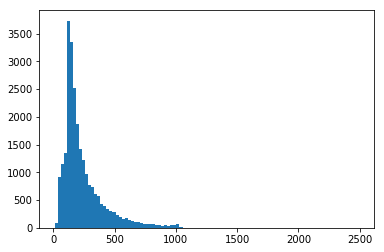

In [0]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [0]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [0]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

('type(y_train):', <type 'numpy.ndarray'>)
('y_train.shape:', (25000,))


In [0]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

('X_test.shape:', (25000,))
('y_test.shape:', (25000,))


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [0]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

('len(X_train[0]):', 100)
('len(X_train[1]):', 100)
('X_train[0]:', array([1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
        407,   16,   82,    2,    8,    4,  107,  117,    2,   15,  256,
          4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
         26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
          4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
        194,    2,   18,    4,  226,   22,   21,  134,  476,   26,  480,
          5,  144,   30,    2,   18,   51,   36,   28,  224,   92,   25,
        104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
          5,   16, 4472,  113,  103,   32,   15,   16,    2,   19,  178,
         32], dtype=int32))


# First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [0]:
K.clear_session()

W0228 08:58:02.375114 139670694201216 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0228 08:58:02.377410 139670694201216 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



In [0]:
# --- create the model
embedding_vector_length = 32

# CODE-RNN1-2
if student:
  model = Sequential()
  model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length, name='embedding_layer'))
  model.add(Lambda(lambda x: K.mean(x, axis = 1))),
  model.add(Dense(1, activation = 'sigmoid'))

  inputs = Input(shape=(max_review_length,))
  layer1 = Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length)(inputs)
  layer2 = Lambda(lambda x: K.mean(x, axis = 1))(layer1)
  predictions = Dense(1, activation = 'sigmoid')(layer2)
  model_func = Model(inputs=inputs, outputs=predictions)
    

    


print(model.summary())
print(model_func.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 32)           160000    
_________________________________________________________________
lambda_4 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________

In [0]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 109us/step - loss: 0.6388 - acc: 0.7215 - val_loss: 0.5622 - val_acc: 0.7776
Epoch 2/10
25000/25000 [==============================] - 2s 99us/step - loss: 0.4868 - acc: 0.8148 - val_loss: 0.4407 - val_acc: 0.8182
Epoch 3/10
25000/25000 [==============================] - 2s 94us/step - loss: 0.3941 - acc: 0.8458 - val_loss: 0.3849 - val_acc: 0.8369
Epoch 4/10
25000/25000 [==============================] - 2s 97us/step - loss: 0.3472 - acc: 0.8595 - val_loss: 0.3596 - val_acc: 0.8430
Epoch 5/10
25000/25000 [==============================] - 2s 96us/step - loss: 0.3188 - acc: 0.8711 - val_loss: 0.3462 - val_acc: 0.8482
Epoch 6/10
25000/25000 [==============================] - 2s 93us/step - loss: 0.2994 - acc: 0.8776 - val_loss: 0.3385 - val_acc: 0.8512
Epoch 7/10
25000/25000 [==============================] - 2s 93us/step - loss: 0.2845 - acc: 0.8836 - val_loss: 0.3345 - val_ac

In [0]:
# --- compile and fit the model
model_func.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_func.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 108us/step - loss: 0.6393 - acc: 0.7273 - val_loss: 0.5631 - val_acc: 0.7738
Epoch 2/10
25000/25000 [==============================] - 2s 91us/step - loss: 0.4875 - acc: 0.8136 - val_loss: 0.4407 - val_acc: 0.8201
Epoch 3/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.3943 - acc: 0.8453 - val_loss: 0.3856 - val_acc: 0.8363
Epoch 4/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.3475 - acc: 0.8601 - val_loss: 0.3593 - val_acc: 0.8440
Epoch 5/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.3191 - acc: 0.8711 - val_loss: 0.3457 - val_acc: 0.8484
Epoch 6/10
25000/25000 [==============================] - 2s 87us/step - loss: 0.2996 - acc: 0.8776 - val_loss: 0.3383 - val_acc: 0.8512
Epoch 7/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.2846 - acc: 0.8836 - val_loss: 0.3353 - val_ac

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [0]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.36%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [0]:
if student:
    # --- START CODE HERE (04)
    E = model.layers[0].get_weights()[0]
    pos_great = word_to_id['great']
    embed_great = E[pos_great,:]
    euc_dist = np.sum((E - np.matlib.repmat(embed_great, E.shape[0],1)) ** 2, 1)
    euc_dist[pos_great] = 10000
    closest = np.where(euc_dist == np.amin(euc_dist))
    closest_word = id_to_word[closest[0][0]]
    print(closest_word)
    # --- END CODE HERE


enjoyed


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [0]:
K.clear_session()

In [0]:
# --- create the model

if student:
  model = Sequential()
  model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
  model.add(LSTM(1, input_shape=(max_review_length, embedding_vector_length))),
  model.add(Dense(1, activation = 'sigmoid'))
    
  inputs = Input(shape=(max_review_length,))
  layer1 = Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length)(inputs)
  layer2 = LSTM(1, input_shape=(max_review_length, embedding_vector_length))(layer1)
  predictions = Dense(1, activation = 'sigmoid')(layer2)
  model_func = Model(inputs=inputs, outputs=predictions)


print(model.summary())
print(model_func.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 160,138
Trainable params: 160,138
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________

In [0]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 37s 1ms/step - loss: 0.6161 - acc: 0.7019 - val_loss: 0.5671 - val_acc: 0.7533
Epoch 2/3
25000/25000 [==============================] - 36s 1ms/step - loss: 0.4868 - acc: 0.8136 - val_loss: 0.4867 - val_acc: 0.8040
Epoch 3/3
25000/25000 [==============================] - 37s 1ms/step - loss: 0.4255 - acc: 0.8401 - val_loss: 0.4620 - val_acc: 0.8030


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [0]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 80.30%


In [0]:
# --- compile and fit the model
model_func.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_func.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 37s 1ms/step - loss: 0.5136 - acc: 0.7818 - val_loss: 0.4589 - val_acc: 0.8107
Epoch 2/3
25000/25000 [==============================] - 34s 1ms/step - loss: 0.4004 - acc: 0.8478 - val_loss: 0.4396 - val_acc: 0.8158
Epoch 3/3
25000/25000 [==============================] - 34s 1ms/step - loss: 0.3463 - acc: 0.8728 - val_loss: 0.4232 - val_acc: 0.8247


In [0]:
# --- Final evaluation of the model
scores = model_func.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 82.47%


# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
